In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.stats import multivariate_normal, bernoulli

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp


import os
import sys

In [2]:
dat = pd.read_csv('./real_data/madelon.csv', header=None)

# ====================== data preprocessing ==========================


Y = dat.iloc[:, -1].to_numpy()
X = dat.iloc[:, :-1].to_numpy()
# X = np.concatenate((X_num, X_cat), axis=1)
X.shape, Y.shape

((2600, 500), (2600,))

In [24]:
pd.value_counts(Y)

0    1300
1    1300
dtype: int64

In [29]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
regr = SVC(gamma='scale')
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
regr = MLPClassifier()
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
regr = RandomForestClassifier()
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
regr = SVC(gamma='scale')
regr.fit(x_train[:, rf], y_train)
print(regr.score(x_test[:, rf], y_test))

0.591025641025641
0.573076923076923
0.7025641025641025
0.6256410256410256


In [17]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
            # reg_clf = Ridge(alpha=0.1)
#             reg_clf = RandomForestRegressor(max_depth=5)
            # reg_clf = ExtraTreesRegressor(n_estimators=50, max_depth=5)
            reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = RandomForestClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [4]:
def metrics_cv(idx, X, Y, cv=5):
#     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf = SVC(gamma='auto')
#     clf = RandomForestRegressor()
    return cross_val_score(clf, X[:, idx], Y, cv=cv)



m, n = X.shape

In [18]:
# ============================= one run ==========================================
start = time.time()

# training steps
batch_size = 64
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=seed)
# scaler_x = StandardScaler()
# x_train = scaler_x.fit_transform(x_train)
# x_test = scaler_x.fit_transform(x_test)

x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed, stratify=y_train)  
r_list = []
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []


for step in range(200):
    print('step: ', step)

    p_list.append(theta)
    idx_select = np.where(theta > 0.9)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
#         actions[i, :] = action.numpy()
        idx = np.random.choice(np.where(action == 1)[0], int(n/10), replace=False)
        tmp = np.zeros(n)
        tmp[idx] = 1
        tmp[idx_select] = 1
        actions[i, :] = tmp


    rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, hiddens=(128, 128), num_iter=100, lr=1e-2, batch_size='auto', dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)


    # sampled natural policy gradient
    log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


    reg = Ridge(alpha=0.05)
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_

    w_norm.append(np.linalg.norm(w))

    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()
print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')

step:  0
average reward: 0.5320383247089263
step:  1
average reward: 0.5334330530401035
step:  2
average reward: 0.5356363195342819
step:  3
average reward: 0.5360203751617075
step:  4
average reward: 0.5285211836998707
step:  5
average reward: 0.5248423350582148
step:  6
average reward: 0.5233869663648125
step:  7
average reward: 0.5337160413971539
step:  8
average reward: 0.5293297218628719
step:  9
average reward: 0.5351511966364813
step:  10
average reward: 0.5265604786545925
step:  11
average reward: 0.5310680789133246
step:  12
average reward: 0.5239731565329884
step:  13
average reward: 0.5281977684346701
step:  14
average reward: 0.5324021668822768
step:  15
average reward: 0.5286828913324709
step:  16
average reward: 0.533089424320828
step:  17
average reward: 0.5259742884864166
step:  18
average reward: 0.5300574062095731
step:  19
average reward: 0.5343426584734801
step:  20
average reward: 0.5276924320827943
step:  21
average reward: 0.5255093790426908
step:  22
average rew

average reward: 0.5423471862871927
step:  182
average reward: 0.5325234476067271
step:  183
average reward: 0.5374151034928849
step:  184
average reward: 0.5443078913324708
step:  185
average reward: 0.5405886157826649
step:  186
average reward: 0.5398609314359638
step:  187
average reward: 0.5455611254851229
step:  188
average reward: 0.5375565976714101
step:  189
average reward: 0.5378395860284605
step:  190
average reward: 0.544388745148771
step:  191
average reward: 0.5316138421733505
step:  192
average reward: 0.5391130336351875
step:  193
average reward: 0.5320181112548512
step:  194
average reward: 0.5396183699870634
step:  195
average reward: 0.5425897477360931
step:  196
average reward: 0.533796895213454
step:  197
average reward: 0.5380821474773609
step:  198
average reward: 0.5388906856403622
step:  199
average reward: 0.5424280401034929
rd: 0 take 1:56:28.291161


In [29]:
for key, value in dictionary.items():
    print(len(key))

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


[0.49 0.5  0.49 0.49 0.51 0.51 0.5  0.49 0.5  0.5  0.51 0.51 0.5  0.5
 0.5  0.5  0.5  0.51 0.5  0.5  0.49 0.48 0.49 0.5  0.49 0.49 0.5  0.5
 0.53 0.49 0.5  0.48 0.5  0.49 0.49 0.49 0.5  0.5  0.49 0.48 0.48 0.5
 0.5  0.49 0.52 0.48 0.5  0.5  0.61 0.5  0.46 0.5  0.49 0.5  0.5  0.48
 0.51 0.5  0.5  0.51 0.49 0.49 0.49 0.5  0.62 0.5  0.5  0.5  0.48 0.49
 0.49 0.5  0.5  0.5  0.5  0.5  0.49 0.5  0.5  0.49 0.49 0.5  0.49 0.5
 0.49 0.49 0.49 0.51 0.49 0.52 0.5  0.49 0.51 0.5  0.5  0.5  0.5  0.5
 0.49 0.49 0.49 0.5  0.5  0.5  0.49 0.58 0.48 0.49 0.49 0.51 0.5  0.49
 0.49 0.5  0.49 0.48 0.5  0.5  0.49 0.5  0.48 0.48 0.49 0.49 0.48 0.51
 0.51 0.5  0.59 0.49 0.49 0.49 0.5  0.49 0.49 0.48 0.5  0.51 0.5  0.52
 0.51 0.49 0.49 0.5  0.49 0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.54
 0.5  0.49 0.5  0.5  0.5  0.5  0.49 0.5  0.49 0.47 0.5  0.51 0.49 0.49
 0.51 0.5  0.5  0.49 0.51 0.5  0.49 0.5  0.5  0.48 0.5  0.5  0.47 0.48
 0.49 0.49 0.5  0.5  0.49 0.5  0.48 0.5  0.5  0.5  0.49 0.49 0.5  0.49
 0.51 0.5  

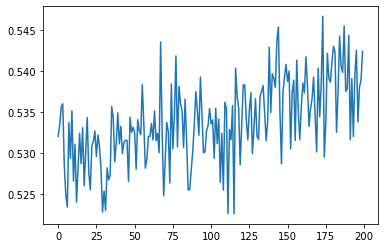

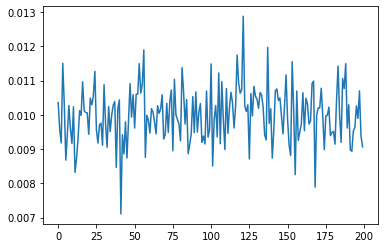

In [19]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.51)[0]+1)
print(np.argsort(theta)[::-1]+1)
plt.figure()
plt.plot(w_norm)

In [20]:
# scaler_x = StandardScaler()
# X = scaler_x.fit_transform(X)

num_selected = 30
dats = np.zeros((num_selected, 4))

for num in range(1, num_selected):

    npg = np.argsort(theta)[::-1][:num]
    print('npg: ', np.sort(npg))

    regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
    regr.fit(x_train, y_train)
    lr2 = np.argsort(regr.coef_[0])[::-1][:num]
    print('logistic_l2: ',  np.sort(lr2))

    regr = RandomForestClassifier(random_state=num)
    regr.fit(x_train, y_train)
    rf = np.argsort(regr.feature_importances_)[::-1][:num]
    print('random_forest: ',  np.sort(rf))
    
    dats[num, 0] = metrics_cv(npg, X, Y).mean() 
    dats[num, 1] = metrics_cv(lr2, X, Y).mean()
    dats[num, 2] = metrics_cv(rf, X, Y).mean()
    
dats[:, 3] = metrics_cv(range(n), X, Y).mean()
    
dats

npg:  [241]
logistic_l2:  [48]
random_forest:  [475]
npg:  [241 475]
logistic_l2:  [ 48 493]
random_forest:  [338 475]
npg:  [241 338 475]
logistic_l2:  [ 48 241 493]
random_forest:  [241 338 475]
npg:  [241 336 338 475]
logistic_l2:  [ 48 241 451 493]
random_forest:  [105 241 338 475]
npg:  [ 64 241 336 338 475]
logistic_l2:  [ 48 241 451 453 493]
random_forest:  [105 241 338 378 475]
npg:  [ 64 241 336 338 378 475]
logistic_l2:  [ 48 241 451 453 475 493]
random_forest:  [105 128 241 338 472 475]
npg:  [ 48  64 241 336 338 378 475]
logistic_l2:  [ 48 128 241 451 453 475 493]
random_forest:  [105 241 318 338 442 472 475]
npg:  [ 48  64 241 336 338 378 472 475]
logistic_l2:  [ 48 128 241 424 451 453 475 493]
random_forest:  [105 128 241 336 338 442 472 475]
npg:  [ 48  64 241 336 338 378 442 472 475]
logistic_l2:  [ 48  64 128 241 424 451 453 475 493]
random_forest:  [ 48 105 128 241 336 338 442 472 475]
npg:  [ 48  64 128 241 336 338 378 442 472 475]
logistic_l2:  [ 48  64 128 241 424 

array([[0.        , 0.        , 0.        , 0.58269231],
       [0.61576923, 0.54615385, 0.61692308, 0.58269231],
       [0.61846154, 0.55884615, 0.67923077, 0.58269231],
       [0.67384615, 0.66038462, 0.67384615, 0.58269231],
       [0.67423077, 0.75269231, 0.71      , 0.58269231],
       [0.67269231, 0.75692308, 0.75653846, 0.58269231],
       [0.75307692, 0.75076923, 0.76076923, 0.58269231],
       [0.75269231, 0.80692308, 0.77269231, 0.58269231],
       [0.79961538, 0.78923077, 0.77576923, 0.58269231],
       [0.80538462, 0.79615385, 0.815     , 0.58269231],
       [0.81576923, 0.82653846, 0.83538462, 0.58269231],
       [0.81807692, 0.82769231, 0.84538462, 0.58269231],
       [0.83      , 0.81576923, 0.83076923, 0.58269231],
       [0.83461538, 0.80730769, 0.85115385, 0.58269231],
       [0.84115385, 0.80769231, 0.84884615, 0.58269231],
       [0.84769231, 0.80153846, 0.85384615, 0.58269231],
       [0.85269231, 0.79038462, 0.85423077, 0.58269231],
       [0.84730769, 0.78038462,

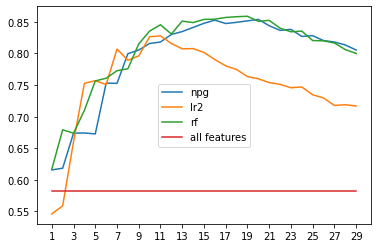

In [21]:
num = 30
plt.plot(range(1, num), dats[1:num, 0], label='npg')
plt.plot(range(1, num), dats[1:num, 1], label='lr2')
plt.plot(range(1, num), dats[1:num, 2], label='rf')
plt.plot(range(1, num), dats[1:num, 3], label='all features')
plt.xticks(range(1, num, 2))
plt.legend()

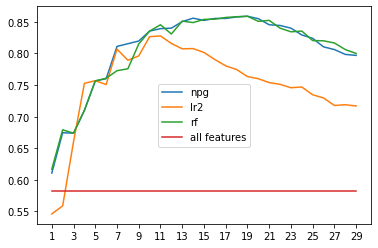

In [9]:
num = 30
plt.plot(range(1, num), dats[1:num, 0], label='npg')
plt.plot(range(1, num), dats[1:num, 1], label='lr2')
plt.plot(range(1, num), dats[1:num, 2], label='rf')
plt.plot(range(1, num), dats[1:num, 3], label='all features')
plt.xticks(range(1, num, 2))
plt.legend()

In [33]:
dats[25, 2]

0.8315384615384616